In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils.load_brad_trace import load_trace, create_concurrency_dataset, load_trace_all_version
from models.concurrency.linear_regression import SimpleLinearReg, SimpleFitCurve
from models.concurrency.xgboost import XGBoostPredictor
np.set_printoptions(suppress=True)

In [2]:
#directory = "/Users/ziniuw/Desktop/research/Data/BRAD_trace/brad_dl_traces/brad_del_trace.task.1706423438/trace/"
#directory = "/Users/ziniuw/Desktop/research/Data/BRAD_trace/brad_dl_traces/brad_del_trace.task.1706488009/trace/"
directory = "/Users/ziniuw/Desktop/research/Data/BRAD_trace/concurrent_3_brad/"
directory = "/Users/ziniuw/Desktop/research/Data/BRAD_trace/io_heavy_redshift/"
raw_trace, trace = load_trace(directory, concat=True)
concurrency_df = create_concurrency_dataset(trace, engine=None, pre_exec_interval=60)
isolated_trace_df = pd.read_csv("/Users/ziniuw/Desktop/research/Data/BRAD_trace/io_heavy_redshift/repeating_olap_batch_warmup.csv")
isolated_trace_df["runtime"] = isolated_trace_df["run_time_s"]
isolated_rt_cache = dict()
for i, rows in isolated_trace_df.groupby("query_idx"):
    isolated_rt_cache[i] = np.median(rows["runtime"])

client 4 trace not found
client 5 trace not found
client 6 trace not found
client 7 trace not found
client 8 trace not found
client 9 trace not found


In [80]:
directory = "/Users/ziniuw/Desktop/research/Data/BRAD_trace/mixed_aurora/"
all_raw_trace, all_trace = load_trace_all_version(directory, 3, concat=True)
all_concurrency_df = []
for trace in all_trace:
    concurrency_df = create_concurrency_dataset(trace, engine=None, pre_exec_interval=60)
    all_concurrency_df.append(concurrency_df)
concurrency_df = pd.concat(all_concurrency_df, ignore_index=True)
isolated_trace_df = pd.read_csv("/Users/ziniuw/Desktop/research/Data/BRAD_trace/io_heavy_aurora/repeating_olap_batch_warmup.csv")
isolated_trace_df["runtime"] = isolated_trace_df["run_time_s"]
isolated_rt_cache = dict()
for i, rows in isolated_trace_df.groupby("query_idx"):
    isolated_rt_cache[i] = np.median(rows["runtime"])

In [71]:
for i, rows in isolated_trace_df.groupby("query_idx"):
    runtime = rows["runtime"].values
    print(i, len(rows), np.mean(runtime), np.min(runtime), np.max(runtime), np.std(runtime))

0 2 159.60091972351074 142.72137093544006 176.48046851158142 16.87954878807068
1 2 2.15029239654541 1.4353909492492676 2.8651938438415527 0.7149014472961426
2 2 6.113356828689575 5.917621374130249 6.309092283248901 0.19573545455932617
3 2 41.51742887496948 41.22735595703125 41.80750179290772 0.290072917938236
4 2 8.569517493247986 8.566256284713745 8.572778701782227 0.0032612085342407227
5 1 13.00282335281372 13.00282335281372 13.00282335281372 0.0
6 1 11.870814800262451 11.870814800262451 11.870814800262451 0.0
7 1 10.001175880432127 10.001175880432127 10.001175880432127 0.0
8 1 97.05856895446776 97.05856895446776 97.05856895446776 0.0
9 1 2.3292765617370605 2.3292765617370605 2.3292765617370605 0.0
10 1 3.0192997455596924 3.0192997455596924 3.0192997455596924 0.0
11 1 130.77851176261902 130.77851176261902 130.77851176261902 0.0
12 1 8.780859470367432 8.780859470367432 8.780859470367432 0.0
13 1 13.238102674484251 13.238102674484251 13.238102674484251 0.0
14 1 11.993283748626707 11.99

0 9 159.60091972351074 78.05456874105666 12.576472997665403 230.57710647583008 77.68821343051177


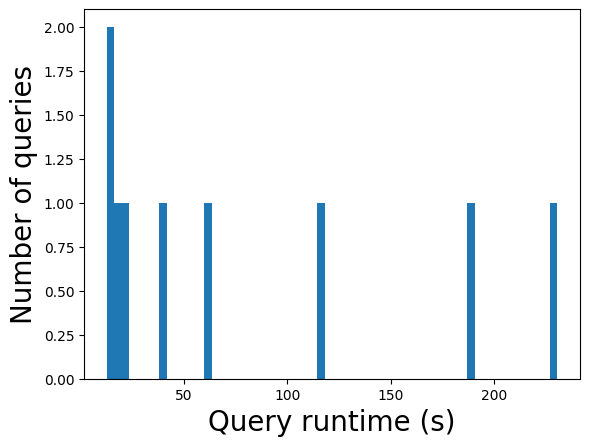

1 9 2.15029239654541 0.48332447475857204 0.0911915302276611 1.5210821628570557 0.45938505156400694


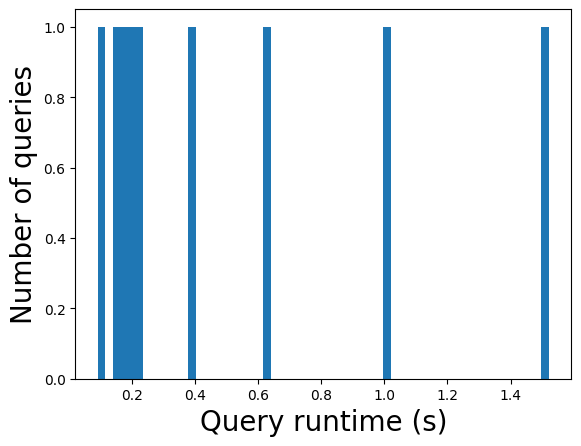

2 9 6.113356828689575 165.7070770793491 20.5003035068512 465.01609206199646 129.8249250437407


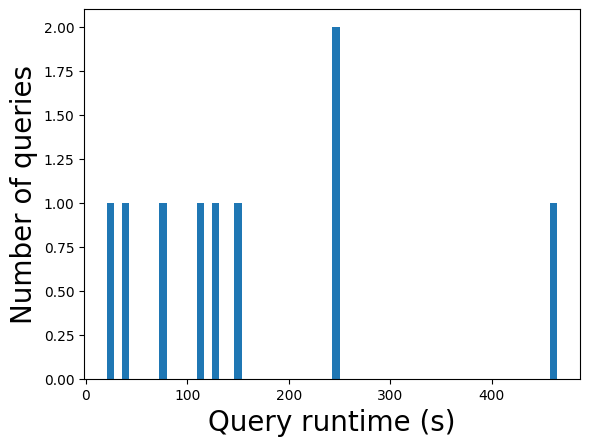

3 10 41.51742887496948 0.402022385597229 0.1635587215423584 1.1334993839263916 0.3019962324689113


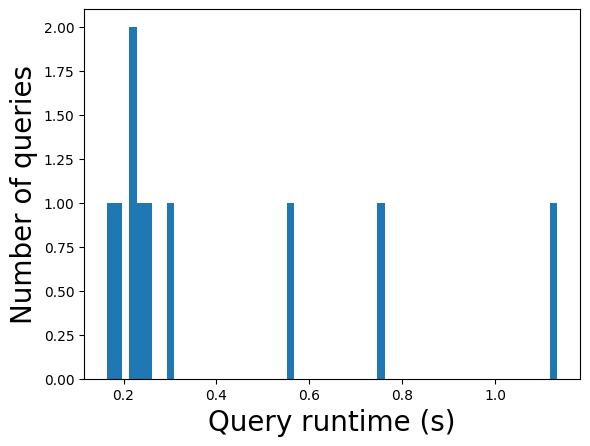

4 11 8.569517493247986 29.070199099454012 2.225593328475952 120.6927046775818 30.89337151105841


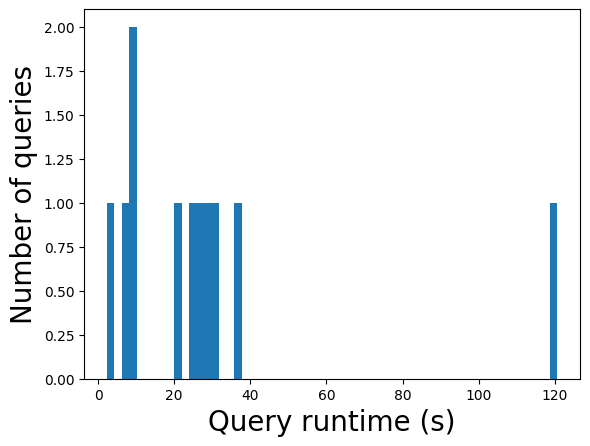

5 9 13.00282335281372 14.131427870856392 2.814318895339966 98.90642762184144 29.97854698061314


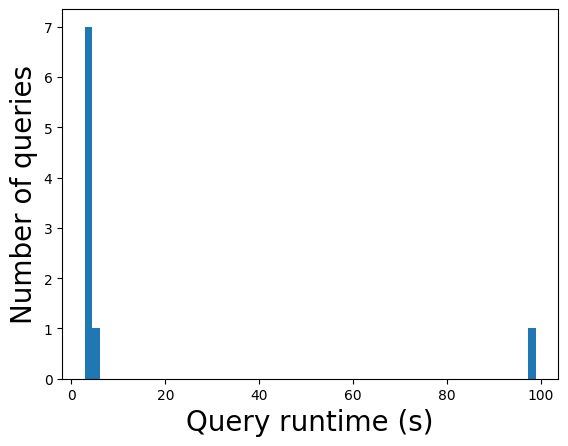

6 9 11.870814800262451 3.060387823316786 2.5194125175476074 3.867015838623047 0.44857271689986344


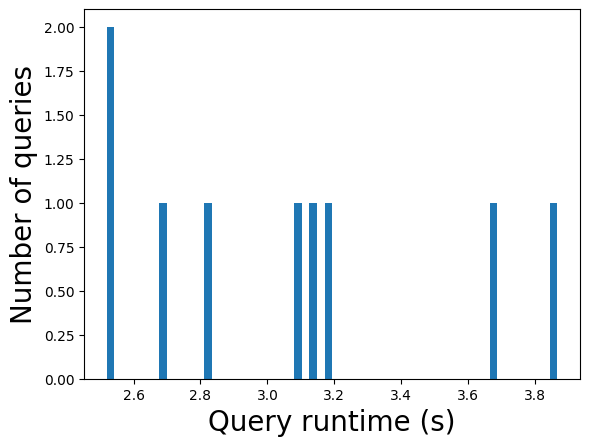

7 10 10.001175880432127 11.398275780677796 1.9339361190795896 47.39509558677673 16.688203524136878


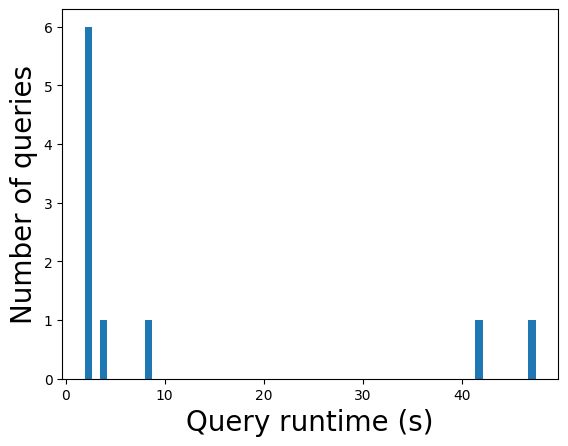

8 10 97.05856895446776 2.883240795135498 0.1878495216369629 18.592463493347168 5.425111717138496


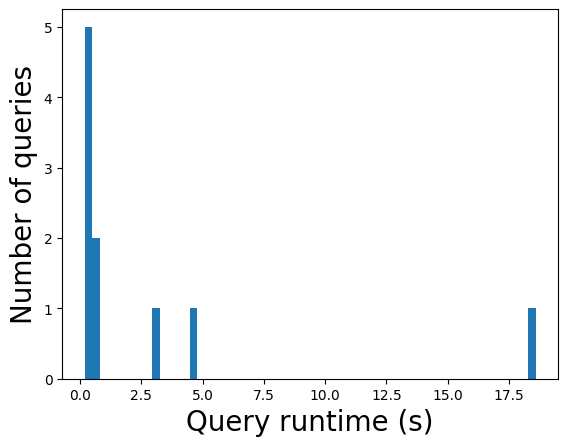

9 10 2.3292765617370605 0.16090602874755855 0.0454521179199218 1.1309733390808103 0.3234159401384784


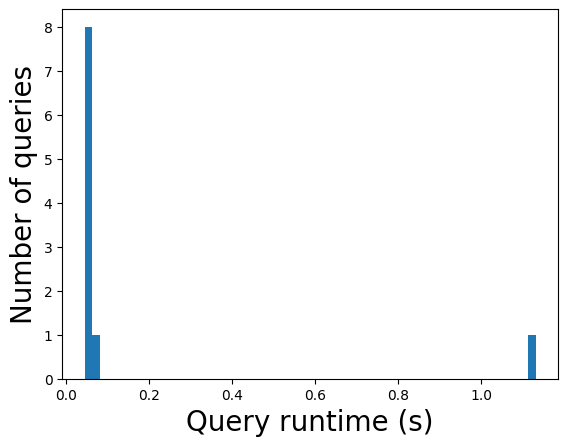

10 9 3.0192997455596924 35.969408088260224 7.012351512908936 128.58163475990295 40.689149749469


In [82]:
for i, rows in concurrency_df.groupby("query_idx"):
    runtime = rows["runtime"].values
    print(i, len(rows), isolated_rt_cache[i], np.mean(runtime), np.min(runtime), np.max(runtime), np.std(runtime))
    if i == 10:
        break
    plt.hist(runtime, bins=60)
    plt.xlabel("Query runtime (s)", fontsize=20)
    plt.ylabel("Number of queries", fontsize=20)
    plt.savefig(f"query_{i}.pdf")
    plt.show()

In [62]:
np.random.seed(40)
train_idx = np.random.choice(len(concurrency_df), size=int(0.8 * len(concurrency_df)), replace=False)
test_idx = [i for i in range(len(concurrency_df)) if i not in train_idx]
eval_trace_df = concurrency_df.iloc[test_idx]
eval_trace_df = eval_trace_df[eval_trace_df['num_concurrent_queries'] > 0]

slr = SimpleLinearReg()
slr.train(concurrency_df.iloc[train_idx], isolated_trace_df=isolated_trace_df)
#predictions, labels = slr.predict(eval_trace_df)
#print("===========Performance for simple linear regression model (per query)=============")
#result_overall, result_per_query = slr.evaluate_performance(eval_trace_df, use_train=True)
predictions_slr, labels = slr.predict(eval_trace_df, use_global=True, use_train=True)
print("===========Performance for simple linear regression model (all query)=============")
result_overall_slr, result_per_query_slr = slr.evaluate_performance(eval_trace_df, use_global=True, use_train=True)

===========Performance for simple linear regression model (all query)=============
50% absolute error is 1.921035259228098, q-error is 1.1646192273670803
90% absolute error is 10.767612626405903, q-error is 1.6181013721557833
95% absolute error is 12.643329090879748, q-error is 1.7594980712505226


In [63]:
slr = SimpleLinearReg()
slr.train(concurrency_df.iloc[train_idx], use_train=False, isolated_trace_df=isolated_trace_df)
#predictions, labels = slr.predict(eval_trace_df, use_train=False)
#print("===========Performance for simple linear regression model (per query & train on Full)=============")
#result_overall, result_per_query = slr.evaluate_performance(eval_trace_df, use_train=False)
predictions_slr, labels = slr.predict(eval_trace_df, use_global=True, use_train=False)
print("===========Performance for simple linear regression model (all query & train on Full)=============")
result_overall_slr, result_per_query_slr = slr.evaluate_performance(eval_trace_df, use_global=True, use_train=False)

===========Performance for simple linear regression model (all query & train on Full)=============
50% absolute error is 1.9459695139920292, q-error is 1.1807331877865015
90% absolute error is 10.019441032577362, q-error is 1.6157302840544756
95% absolute error is 11.873765403287939, q-error is 1.7053670107085344


In [64]:
sfc = SimpleFitCurve()
sfc.train(concurrency_df.iloc[train_idx], isolated_trace_df=isolated_trace_df)
#predictions, labels = sfc.predict(eval_trace_df)
#print("===========Performance for simple curve fitting model (per query)=============")
#result_overall, result_per_query = sfc.evaluate_performance(eval_trace_df, use_train=True)
predictions_sfc, labels = sfc.predict(eval_trace_df, use_global=True)
print("===========Performance for simple curve fitting model (all query)=============")
result_overall_sfc, result_per_query_sfc = sfc.evaluate_performance(eval_trace_df, use_global=True, use_train=True)

===========Performance for simple curve fitting model (all query)=============
50% absolute error is 1.9522062606934876, q-error is 1.1988421947774688
90% absolute error is 13.5606804680123, q-error is 1.7614524148784525
95% absolute error is 20.241088395758652, q-error is 1.9251416454479715


/Users/ziniuw/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [65]:
sfc = SimpleFitCurve()
sfc.train(concurrency_df.iloc[train_idx], use_train=False, isolated_trace_df=isolated_trace_df)
#predictions, labels = sfc.predict(eval_trace_df, use_train=False)
#print("===========Performance for simple curve fitting model (per query)=============")
#result_overall, result_per_query = sfc.evaluate_performance(eval_trace_df, use_train=False)
predictions_sfc, labels = sfc.predict(eval_trace_df, use_global=True, use_train=False)
print("===========Performance for simple curve fitting model (all query & train on full)=============")
result_overall_sfc, result_per_query_sfc = sfc.evaluate_performance(eval_trace_df, use_global=True, use_train=False)

===========Performance for simple curve fitting model (all query & train on full)=============
50% absolute error is 3.134463566065632, q-error is 1.3531158320768615
90% absolute error is 14.269901166408628, q-error is 2.006179594911632
95% absolute error is 20.162820091047934, q-error is 2.3175645158954556


In [67]:
import numpy as np
from models.concurrency.base_model import ConcurPredictor
from xgboost import XGBRegressor


class XGBoostPredictor(ConcurPredictor):
    """
    Consider k unique concurrent queries (or group into k classes)
    For each query represent it as k-dimensional one hot vector
         Then, identify its concurrent queries, represent them as a k-dimensional vector
         [rt_q1, rt_q2, ..., rt_qk], where rt_qi is the runtime of query i running in isolation
         Concatenate two features together to build simple XGboost model to predict the runtime
    """
    def __init__(self, k=100):
        self.clustering = None
        self.isolated_rt_cache = dict()
        self.xgboost = None
        self.k = k

    def train(self, trace_df, use_train=True, isolated_trace_df=None):
        self.get_isolated_runtime_cache(trace_df, isolated_trace_df)
        concurrent_df = trace_df[trace_df['num_concurrent_queries'] > 0]

        global_y = []
        global_x = []
        for i, rows in concurrent_df.groupby("query_idx"):
            if i not in self.isolated_rt_cache or len(rows) < 10:
                continue
            if use_train:
                concur_info = rows["concur_info_train"].values
            else:
                concur_info = rows["concur_info"].values
            global_y.append(rows["runtime"].values)
            query_feature = np.zeros((len(rows), self.k))
            query_feature[:, i] = self.isolated_rt_cache[i]

            concur_query_feature = np.zeros((len(rows), self.k))
            for j in range(len(rows)):
                for c in concur_info[j]:
                    if c[0] in self.isolated_rt_cache:
                        concur_query_feature[j, c[0]] += self.isolated_rt_cache[c[0]]
                    else:
                        concur_query_feature[j, c[0]] += 2
            x = np.concatenate((query_feature, concur_query_feature), axis=1)
            global_x.append(x)
        global_y = np.concatenate(global_y)
        global_x = np.concatenate(global_x)
        model = XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=1.0,
                             eval_metric="rmse")
        train_idx = np.random.choice(len(global_y), size=int(0.8 * len(global_y)), replace=False)
        val_idx = [i for i in range(len(global_y)) if i not in train_idx]
        model.fit(global_x[train_idx], global_y[train_idx],
                  eval_set=[(global_x[val_idx], global_y[val_idx])],
                  early_stopping_rounds=100,
                  verbose=False
                 )
        self.xgboost = model


    def predict(self, eval_trace_df, use_global=True, use_train=True):
        predictions = dict()
        labels = dict()
        for i, rows in eval_trace_df.groupby("query_idx"):
            if i not in self.isolated_rt_cache or len(rows) < 10:
                continue
            label = rows["runtime"].values
            labels[i] = label
            if use_train:
                concur_info = rows["concur_info_train"].values
            else:
                concur_info = rows["concur_info"].values
            query_feature = np.zeros((len(rows), self.k))
            query_feature[:, i] = self.isolated_rt_cache[i]

            concur_query_feature = np.zeros((len(rows), self.k))
            for j in range(len(rows)):
                for c in concur_info[j]:
                    if c[0] in self.isolated_rt_cache:
                        concur_query_feature[j, c[0]] += self.isolated_rt_cache[c[0]]
                    else:
                        concur_query_feature[j, c[0]] += 2
            x = np.concatenate((query_feature, concur_query_feature), axis=1)
            pred = self.xgboost.predict(x)
            pred = np.maximum(pred, 0.001)
            predictions[i] = pred
        return predictions, labels



In [68]:
xgb = XGBoostPredictor(k=24)
xgb.train(concurrency_df.iloc[train_idx], isolated_trace_df=isolated_trace_df)
predictions_xgb, labels = xgb.predict(eval_trace_df)
print("===========Performance for XGBoost model=============")
result_overall_xgb, result_per_query_xgb = xgb.evaluate_performance(eval_trace_df, use_train=True)

/Users/ziniuw/miniconda3/envs/brad/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


===========Performance for XGBoost model=============
50% absolute error is 0.9633944034576416, q-error is 1.0786720641613046
90% absolute error is 5.231059885025024, q-error is 1.2560487882488656
95% absolute error is 7.768443715572356, q-error is 1.3409269499993568


In [69]:
xgb = XGBoostPredictor(k=24)
xgb.train(concurrency_df.iloc[train_idx], use_train=False, isolated_trace_df=isolated_trace_df)
predictions_xgb, labels = xgb.predict(eval_trace_df, use_train=False)
print("===========Performance for XGBoost model (train on full)=============")
result_overall_xgb, result_per_query_xgb = xgb.evaluate_performance(eval_trace_df, use_train=False)

===========Performance for XGBoost model (train on full)=============
50% absolute error is 0.6985369920730591, q-error is 1.0545662816659784
90% absolute error is 3.056750512123108, q-error is 1.2479241624959778
95% absolute error is 4.359630882740019, q-error is 1.3306765880227165


In [52]:
i = 2
print(isolated_trace_df["runtime"].iloc[i])
idx = np.argsort(predictions_xgb[i])
np.stack((predictions_xgb[i][idx], predictions_sfc[i][idx], labels[i][idx]), axis=1)

5.917621374130249


array([[  0.43273214,   6.77468745,   2.87737322],
       [  3.61037302,   6.77468745,   2.75083995],
       [  6.16629744,   6.77468745,  30.65666604],
       [  8.15269279,   6.77468745,   2.63277221],
       [  8.15269279,   6.77468745,   2.62743878],
       [  8.15269279,   6.77468745,   2.77575445],
       [ 10.97294998,   6.77468745,   2.78701282],
       [ 13.13975525,   6.77468745,  31.37080503],
       [ 14.50670242,   6.11335683,   5.67288303],
       [ 15.72630692,   6.11335683,  72.25125957],
       [ 15.72630692,   6.44402214,  11.37893105],
       [ 17.38875961,   6.77468745,  12.71168494],
       [ 17.38875961,   6.77468745,  16.73676109],
       [ 25.59719849,   6.77468745,  31.34772253],
       [ 26.57924652,   6.77468745,  29.98712444],
       [ 27.43367958,   6.77468745, 112.29325414],
       [ 31.51845551,   6.77468745,  34.93882012],
       [ 31.51845551,   6.77468745,  34.70703506],
       [ 36.28924179,   6.77468745,  70.27246594],
       [ 38.06968307,   6.77468

In [42]:
for t, m in zip(eval_trace_df.query(f"query_idx == {i}")["runtime"].values, eval_trace_df.query(f"query_idx == {i}")["concur_info_train"].values):
    print(t, m)

32.392929792404175 [(11, 2171.236734, 2268.0254517467347), (8, 2180.806818, 2280.574904194992)]
105.99190831184389 [(23, 2380.0116580000004, 2405.0938544740757), (21, 2392.751384, 2443.4870400230257)]
40.98465251922608 [(11, 45.255973, 213.95711435742186), (6, 116.27495900000001, 129.26804295385745)]
4.146631479263306 [(8, 2201.720943, 2352.667964961212), (8, 2257.549457, 2352.8248733742066)]
208.43091917037964 [(21, 5393.60857, 5575.46965994484), (23, 5542.911962, 5575.847163644898)]
64.50340628623962 [(19, 12530.740322, 12633.787255889389), (3, 12618.370282, 12637.092660253937)]
7.12125039100647 [(0, 15808.421051, 15944.932392333389), (0, 15811.041049, 15944.793072935317)]
124.48280572891235 [(20, 17260.881817, 17439.675028698533), (5, 17360.987241000003, 17413.113462179965)]
31.829721450805664 [(0, 17407.088041000003, 17531.570846728915), (0, 17478.749812000002, 17531.724607341494)]
191.81122517585757 [(20, 18833.226802, 18991.946910032228), (18, 18969.856519, 18978.974367157884)]
8

In [ ]:
import os
import re
dir = "/Users/ziniuw/Desktop/research/Data/join-order-benchmark/"
all_queries = []
i = 0
name_map = dict()
for file in os.listdir(dir):
    if str(file)[0].isnumeric():
        name_map[i] = file.split(".sql")[0]
        file = os.path.join(dir, file)
        with open(file, "r") as f:
            sql = f.read()
        sql = re.sub(r"\s+", ' ', sql)
        all_queries.append(sql)
        i += 1

In [ ]:
len(all_queries)

In [ ]:
with open(os.path.join(dir, "imdb_job.sql"), "w") as f:
    for q in all_queries:
        f.write(q + "\n")

In [ ]:
name_map